------
### Metis: Restaurant Personalized Recommender
>  Neha Gupta                
>  Date: 3/28/2019
-------

### Import Libraries

In [1]:
#Basic
import os
import re
import string
import numpy as np 
import pandas as pd 
import pickle
from math import sqrt


#nltk 
import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
# nltk.download('stopwords')

#matplot 
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt


#scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import model_selection as cv

#SciPy
from scipy import sparse
from scipy.sparse.linalg import svds

### Functions to Pre-processing the data

In [2]:
english_words = set(nltk.corpus.words.words())
english_stopwords = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[\w|!]+')

In [3]:
def to_be_removed(word):
    word_tokens_lower = word.lower()
    if word_tokens_lower in english_stopwords:
        return True
    if word_tokens_lower in english_words:
        return False
    return True

In [4]:
def clear_word(word):
    lemma_v = wordnet_lemmatizer.lemmatize(word, pos='v')
    lemma_n = wordnet_lemmatizer.lemmatize(word)
    w = ''
    if word != lemma_v:
        w = lemma_v
    else:
        w = lemma_n
    porter = PorterStemmer()
    return porter.stem(w)

In [5]:
def preprocess_text(text):
    ## Remove puncuation
    text = text.translate(string.punctuation)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\=", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"\\n", "", text)

    ## Convert words to lower case and split them
    text = text.lower().split()

    text = [clear_word(w) for w in text if len(w) > 2]
    text = [w for w in text if not to_be_removed(w)]
    text = " ".join(text)
    return text

### Loading the dataframe

In [6]:
%%time
review_business_df = pd.read_pickle('review_business_with_required_data_df.pkl')

CPU times: user 22.5 s, sys: 1min 16s, total: 1min 38s
Wall time: 4min 4s


### Function to get restaurant data

In [7]:
def compare_strings(text, categories):
    res = []
    if text is None:
        res.append(False)
    else:
        for x in categories:
            res.append(x.lower() in text.lower())
    return any(res)

In [8]:
def get_all_restaurant_reviews(reviews_df, state, city=None, selected_categories=['restaurant','restaurants']):
#     reviews_df.dropna()
#     reviews_df['cond'] = reviews_df['categories'].apply(lambda x: any(i.lower() in x.lower() for i in selected_categories))
    reviews_df.dropna(how='all')
    reviews_df['cond'] = reviews_df['categories'].apply(compare_strings, args=(selected_categories,))
    reviews_df = reviews_df.loc[reviews_df.cond]
    restaurants_df = reviews_df[reviews_df['state'].str.contains(state, case=False, na=False)]
    if city is not None:
        restaurants_df = reviews_df[reviews_df['city'].str.contains(city, case=False, na=False)]
    restaurants_df['text'] = restaurants_df['text'].apply(preprocess_text)
    return restaurants_df

## Getting states data from dataset

In [9]:
# %%time
# SouthCarolina = get_all_restaurant_reviews(review_business_df, 'sc', selected_categories=['restaurant','restaurants'])

# SouthCarolina.to_pickle('SouthCarolina.pkl')

# SouthCarolina = pd.read_pickle('SouthCarolina.pkl')
# SouthCarolina = SouthCarolina[SouthCarolina['city'].str.contains('Rock Hill', case=False, na=False)]

# len(SouthCarolina.business_id.unique())

#### NorthCarolina State

In [10]:
# %%time
# NorthCarolina = get_all_restaurant_reviews(review_business_df, 'NC',  selected_categories=['restaurant','restaurants'])

# NorthCarolina.to_pickle('NorthCarolina.pkl')

NorthCarolina = pd.read_pickle('NorthCarolina.pkl')
NorthCarolina = NorthCarolina[NorthCarolina['city'].str.contains('Charlotte', case=False, na=False)]

In [11]:
# NorthCarolina = NorthCarolina.loc[NorthCarolina['postal_code'].isin(['28202','2803','2804','2805'])]

In [12]:
NorthCarolina['cond'] = NorthCarolina['categories'].apply(lambda x: all(i.lower() in x.lower() for i in ['Restaurant','Indian']))
NorthCarolina = NorthCarolina.loc[NorthCarolina.cond]
NorthCarolina = NorthCarolina[(NorthCarolina['stars_x'] >= 3) ]

In [13]:
NorthCarolina.business_id.unique().shape

(55,)

### Pittsburg State

In [14]:
%%time
# Penn = get_all_restaurant_reviews(review_business_df, 'PA', 'Pittsburgh',  selected_categories=['restaurant','restaurants'])

# Penn.to_pickle('Penn.pkl')

Penn = pd.read_pickle('Penn.pkl')
Penn = Penn[Penn['city'].str.contains('Pittsburgh', case=False, na=False)]

len(Penn.business_id.unique())

CPU times: user 558 ms, sys: 121 ms, total: 679 ms
Wall time: 1.21 s


In [15]:
Penn['cond'] = Penn['categories'].apply(lambda x: all(i.lower() in x.lower() for i in ['Restaurant','Indian']))
Penn = Penn.loc[Penn.cond]
Penn = Penn[(Penn['stars_x'] >= 3) ]

In [16]:
# fdf.user_id.unique().shape

In [17]:
# %%time
# Alabama = get_all_restaurant_reviews(review_business_df, 'ab', selected_categories=['restaurant','restaurants'])

# Alabama.to_pickle('Alabama.pkl')

# Alabama = pd.read_pickle('Alabama.pkl')

In [18]:
user_id = 'FacesK7Cwogzb0dYIWyDDQ'
filtered = Penn[Penn['user_id'] == user_id]
res = []
for bid in list(filtered.business_id.unique()):
    res.append(Penn[Penn['business_id'] == bid])
Penn = pd.concat(res)

In [19]:
Penn.shape

(129, 15)

### Function to get user data

In [20]:
def get_user_data(reviews_df, userid, selected_categories=['restaurant'], ignore_userid=False):
    reviews_df['cond'] = reviews_df['categories'].apply(lambda x: all(i.lower() in x.lower() for i in selected_categories))
    reviews_df = reviews_df.loc[reviews_df.cond]
    filtered_data = reviews_df[(reviews_df['stars_x'] >= 3) ]
    if not ignore_userid:
        filtered_data = filtered_data[(reviews_df['user_id'] == userid)]
    sorted_data =  filtered_data.sort_values(by='stars_x', ascending=False).head(10)#Note: if one business will return
    return sorted_data



## Getting user data from the state Alabama

In [21]:
## Getting user data from the state Alabama
user_data = get_user_data(Penn,user_id, ['Restaurant', 'Indian'])
# Alabama.groupby(['user_id']).agg(['count'])
# Alabama['user_id'].value_counts()
user_data.shape

(4, 15)

In [22]:
 Penn.city.unique()

array(['Pittsburgh'], dtype=object)

In [23]:
columns = ['business_id', 'city', 'latitude', 'longitude', 'name', 'postal_code']
business_avg = Penn.groupby(columns).agg({'stars_x': ['mean']})
business_avg.columns = ["_".join(y) for y in business_avg.columns.ravel()]
sorted_data = business_avg.sort_values(by='stars_x_mean', ascending=False).head(10)
sorted_data.columns.values

array(['stars_x_mean'], dtype=object)

### If user has not reviewed business in same category pick top 5 reviews in that category with the help of star rating

In [24]:
if user_data.empty:
    user_data = get_user_data(Penn,'BfnYXZEfWNdmW9VbWVeg7Q', ['Restaurants', 'Indian'], ignore_userid=True)

In [25]:
# user_data

### Content based filtering

__Profile vector: This vector containts user reviews.__

__Item vector: This vector containts restaurant features.__

In [26]:
combined_data = pd.concat([Penn, NorthCarolina])

In [27]:
combined_data.user_id.unique().shape

(2454,)

In [28]:
business_data = pd.DataFrame(
        combined_data.groupby('business_id').agg({'review_id': 'count','text': lambda x: "{%s}" % ' '.join(x), 'stars_x': 'mean'}))
business_data.rename(index=str, columns={"review_id": "review_count"}, inplace=True)
business_data.reset_index(inplace=True)

business_data.head(2)

,business_id,review_count,text,stars_x
0,01I5pFCvJrrGuY3A-KoNIA,27,{review base event host week ago within day in...,4.074074
1,0htWficVWZV20ATE8cs7YA,17,{love rice wrap hit new place food hand restau...,4.411765


In [29]:
business_data.quantile(0.5)

review_count    23.000000
stars_x          4.276786
Name: 0.5, dtype: float64

### TD-IDF

In [30]:
%%time
tfidf = TfidfVectorizer(
        ngram_range=(1,3),
        min_df=0.0001,
        stop_words='english',
        max_features=2000)
tfidf_matrix = tfidf.fit_transform(business_data['text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=business_data.index.tolist())

CPU times: user 1.22 s, sys: 90.2 ms, total: 1.31 s
Wall time: 2.3 s


In [31]:
tfidf_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.0,0.015852,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.098708,0.022557,0.0,0.020552,0.0,0.0,0.067671,0.0,0.02436
1,0.033994,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.057423,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000


### Dimentionality Reduction

In [32]:
%%time
rest_revfeature = pd.SparseDataFrame(tfidf_matrix)
rest_revfeature = rest_revfeature.set_index(business_data.business_id)
rest_revfeature = rest_revfeature.fillna(0)

rest_revfeature.head(2)

tfidf.get_feature_names()[:10]

pca = PCA()
rest_pcafeature = pca.fit_transform(rest_revfeature)

CPU times: user 4.41 s, sys: 3.37 s, total: 7.78 s
Wall time: 18.7 s


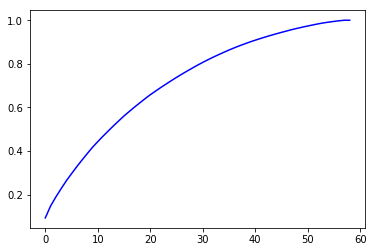

In [33]:
vr = pca.explained_variance_ratio_
# compute cumulative explained variance ratio
vr_cum = [sum(vr[:i+1]) for i in range(len(vr))]
# plot explained variance ratio vs the number of PCA components
plt.plot(list(range(len(vr))),vr_cum, color='blue')

In [34]:
# keep only the top 58 PCA components
rest_pcafeature = pd.DataFrame(rest_pcafeature[:, :58], index=rest_revfeature.index,
                               columns=[str(i) for i in np.arange(1, 59)])
rest_pcafeature.columns.name = 'pca_components'
rest_pcafeature['root_squared_sum'] = rest_pcafeature.apply(lambda row: np.sqrt(sum([i * i for i in row])), axis=1)
rest_pcafeature = rest_pcafeature.drop('root_squared_sum', axis=1).divide(rest_pcafeature.root_squared_sum, axis=0)


rest_pcafeature.head(2)

pca_components,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
business_id,,,,,,,,,,,,,,,,,,,,,
01I5pFCvJrrGuY3A-KoNIA,-0.085112,0.203159,0.059225,0.102015,-0.085219,-0.061280,-0.153762,0.105379,-0.040583,-0.199048,...,-0.047982,0.004789,-0.001775,-0.033677,-0.008188,0.021139,-0.008316,-0.002095,0.002328,0.005156
0htWficVWZV20ATE8cs7YA,0.388913,-0.247245,0.670901,-0.353491,-0.131124,-0.060199,-0.009556,-0.033404,0.022370,0.072707,...,-0.045189,-0.047033,0.028674,-0.038250,0.029275,-0.036740,-0.009907,0.019870,-0.015265,-0.007271


## Profile Vector

In [35]:
%%time
# build user preference profile by compute a weighted sum of the restaurant vectors for all rated items by the user, with weights being the user's rating
user_pcafeature = pd.merge(combined_data[['user_id','business_id','stars_x']], rest_pcafeature, how='inner',left_on='business_id',right_index=True).drop('business_id', axis=1)
user_pcafeature.loc[:, '1':'58'] = user_pcafeature.loc[:,'1':'58'].multiply(user_pcafeature.stars_x, axis=0)
user_pcafeature = user_pcafeature.drop('stars_x', axis=1).groupby('user_id').sum()
user_pcafeature['root_squared_sum'] = user_pcafeature.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
user_pcafeature = user_pcafeature.drop('root_squared_sum', axis=1).divide(user_pcafeature.root_squared_sum, axis=0)

CPU times: user 219 ms, sys: 16.6 ms, total: 236 ms
Wall time: 299 ms


In [36]:
%%time
user_pcafeature.head(1)

CPU times: user 2.02 ms, sys: 2.66 ms, total: 4.68 ms
Wall time: 28.9 ms


,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
user_id,,,,,,,,,,,,,,,,,,,,,
-0CTuvVqlEGeWvOt82B7Hg,-0.111541,-0.401781,-0.010329,0.125515,-0.196425,0.07082,-0.164956,0.005874,-0.010793,-0.037592,...,0.049138,0.088814,-0.016731,0.07285,-0.02192,0.084582,0.025057,0.01353,0.015223,-0.01909


In [37]:
globe_mean = ((business_data.stars_x * business_data.review_count).sum())/(business_data.review_count.sum())
k = 23 # set strength k to 23, which is the 50% quantile of the review counts for all businesses
business_data['adjusted_score'] = (business_data.review_count * business_data.stars_x + k * globe_mean)/(business_data.review_count + k)

sim_matrix = cosine_similarity(user_pcafeature.loc[user_id].values.reshape(1, -1), rest_pcafeature)
sim_matrix = sim_matrix.flatten()
sim_matrix = pd.Series(sim_matrix, index = rest_pcafeature.index)
sim_matrix.name = 'similarity_score'

In [38]:
recomm = business_data
# pairing the computed cosine similarity score with the business_id by matching the corresponding matrix indices of the business_id
recomm = pd.concat([sim_matrix, recomm.set_index('business_id')], axis=1, join='inner').reset_index()

# filter to unrated business_id only by the user_id of interest if a personal history is available      
busi_rated = combined_data[combined_data.user_id == user_id].business_id.unique()
recomm = recomm[~recomm.business_id.isin(busi_rated)]

# sort the recommendation by the cosine similarity score in descending order
cb_recomm = recomm.sort_values('similarity_score', ascending=False).reset_index(drop=True)

In [39]:
cb_recomm.head(2)

,business_id,similarity_score,review_count,text,stars_x,adjusted_score
0,LpyndkMvevIQA-JHoReHNw,0.187285,112,{food good good chicken excel want could use c...,4.276786,4.284095
1,o8nauTizH7H_GEAeV6HfMg,0.178746,85,{birthday banquet hall order food restaur like...,4.435294,4.410675


### RMSE of Content-Based

In [40]:
# orders_df['Value'] = orders_df.Prices * orders_df.Amount

cb_recomm['pred'] = cb_recomm.similarity_score * 5
sqrt(mean_squared_error(list(cb_recomm.adjusted_score),list(cb_recomm.pred)))

4.484151652361508

In [41]:
cb_recomm.merge(NorthCarolina, on='business_id', how='inner')

,business_id,similarity_score,review_count_x,text_x,stars_x_x,adjusted_score,pred,review_id,stars_x_y,text_y,...,address,categories,city,latitude,longitude,name,postal_code,review_count_y,state,cond
0,LpyndkMvevIQA-JHoReHNw,0.187285,112,{food good good chicken excel want could use c...,4.276786,4.284095,0.936425,18IWS3UmrHKHaEyL5utJMg,4.0,food good good,...,5909 South Blvd,"Restaurants, Pakistani, Indian",Charlotte,35.155407,-80.875309,Jaipur Indian Restaurant,28217,151,NC,True
1,LpyndkMvevIQA-JHoReHNw,0.187285,112,{food good good chicken excel want could use c...,4.276786,4.284095,0.936425,idtqmqCPiEGByFGCItuM_w,4.0,chicken excel want could use chicken small pri...,...,5909 South Blvd,"Restaurants, Pakistani, Indian",Charlotte,35.155407,-80.875309,Jaipur Indian Restaurant,28217,151,NC,True
2,LpyndkMvevIQA-JHoReHNw,0.187285,112,{food good good chicken excel want could use c...,4.276786,4.284095,0.936425,obXrTAexXhB6qxtFmYt_8w,3.0,quit good group sit even buffet good wide sele...,...,5909 South Blvd,"Restaurants, Pakistani, Indian",Charlotte,35.155407,-80.875309,Jaipur Indian Restaurant,28217,151,NC,True
3,LpyndkMvevIQA-JHoReHNw,0.187285,112,{food good good chicken excel want could use c...,4.276786,4.284095,0.936425,MHV9_Pgvah1N2gkza_2Qvg,5.0,best far spice ton flavor come back,...,5909 South Blvd,"Restaurants, Pakistani, Indian",Charlotte,35.155407,-80.875309,Jaipur Indian Restaurant,28217,151,NC,True
4,LpyndkMvevIQA-JHoReHNw,0.187285,112,{food good good chicken excel want could use c...,4.276786,4.284095,0.936425,Pw1-Fp4Nva_QpYsPs08Shg,4.0,love buffet well mango buffet good good food p...,...,5909 South Blvd,"Restaurants, Pakistani, Indian",Charlotte,35.155407,-80.875309,Jaipur Indian Restaurant,28217,151,NC,True
5,LpyndkMvevIQA-JHoReHNw,0.187285,112,{food good good chicken excel want could use c...,4.276786,4.284095,0.936425,m3JbYCG9kW2VdzseSwAPhQ,5.0,love place buffet way sure place lunch good pa...,...,5909 South Blvd,"Restaurants, Pakistani, Indian",Charlotte,35.155407,-80.875309,Jaipur Indian Restaurant,28217,151,NC,True
6,LpyndkMvevIQA-JHoReHNw,0.187285,112,{food good good chicken excel want could use c...,4.276786,4.284095,0.936425,XgT49yWLf51X4VRxOk1WhA,4.0,buffet dure lunch time minim amount food enoug...,...,5909 South Blvd,"Restaurants, Pakistani, Indian",Charlotte,35.155407,-80.875309,Jaipur Indian Restaurant,28217,151,NC,True
7,LpyndkMvevIQA-JHoReHNw,0.187285,112,{food good good chicken excel want could use c...,4.276786,4.284095,0.936425,twwANENteUX4TQCYF7JVnA,4.0,veri good food best place lay rather food wife...,...,5909 South Blvd,"Restaurants, Pakistani, Indian",Charlotte,35.155407,-80.875309,Jaipur Indian Restaurant,28217,151,NC,True
8,LpyndkMvevIQA-JHoReHNw,0.187285,112,{food good good chicken excel want could use c...,4.276786,4.284095,0.936425,0JZsbh3Kgtbo1gn7hd1f1Q,4.0,food great spice level disappoint would prefer...,...,5909 South Blvd,"Restaurants, Pakistani, Indian",Charlotte,35.155407,-80.875309,Jaipur Indian Restaurant,28217,151,NC,True
9,LpyndkMvevIQA-JHoReHNw,0.187285,112,{food good good chicken excel want could use c...,4.276786,4.284095,0.936425,Qjd8epUAElUoVb1gBXAq9w,5.0,buffet sever time think regard look like cater...,...,5909 South Blvd,"Restaurants, Pakistani, Indian",Charlotte,35.155407,-80.875309,Jaipur Indian Restaurant,28217,151,NC,True


### Item-Item collaborative filtering

__Calculate the number of unique users and restaurants__

In [42]:
# filtered1 = SouthCarolina[SouthCarolina['city'].str.contains('Rock Hill', case=False, na=False)]
# filtered2 = Alabama[Alabama['city'].str.contains('Calgary', case=False, na=False)]


# filtered2= filtered2[filtered2['user_id'] == '-0zUpn_6kTWXHWzB85u7yA']
# list(filtered2.business_id.unique())
# res = []
# for bid in list(filtered2.business_id.unique()):
#     res.append(filtered2[filtered2['business_id'] == bid])
# filtered3 = pd.concat(res)

# combined_data = pd.concat([filtered1, filtered3])

In [43]:
n_restaurants = combined_data.business_id.unique().shape[0]
restaurantList = list(combined_data.business_id.unique())

user_avg_review = pd.DataFrame(
        combined_data.groupby('user_id').agg({'stars_x': 'mean'})).rename(index=str, columns={"stars_x": "user_avg_review"})

# combined_data = combined_data.drop(columns=['user_avg_review_y']).rename(index=str, columns={"user_avg_review_x": "user_avg_review"})

combined_data = pd.merge(combined_data, user_avg_review, on='user_id')

__Create a user-item matrix which can be used to calculate the similarity between business and user__

In [44]:
n_users = combined_data.user_id.unique().shape[0]
n_items = combined_data.business_id.unique().shape[0]

In [45]:
n_users

2454

In [46]:
n_items

59

In [47]:
%%time
users = pd.DataFrame(combined_data.user_id.unique())
business = pd.DataFrame(combined_data.business_id.unique())

users.columns=['user_id']
business.columns = ['business_id']

data_matrix = np.zeros((n_users, n_items))
for line in combined_data.itertuples():
    i = users[users['user_id']==line[5]].index.item()
    j = business[business['business_id']==line[1]].index.item()
    data_matrix[i, j] = line[3]

CPU times: user 6.81 s, sys: 109 ms, total: 6.92 s
Wall time: 7.89 s


#### Split the dataset into testing and training

In [48]:
train_data, test_data = cv.train_test_split(combined_data, test_size=0.25 )

#### Create two user-item matrices, one for train dataset and another for test dataset

In [49]:
%%time
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    i = users[users['user_id']==line[5]].index.item()
    j = business[business['business_id']==line[1]].index.item()
    train_data_matrix[i, j] = line[3]

CPU times: user 5.85 s, sys: 97.5 ms, total: 5.95 s
Wall time: 6.41 s


In [50]:
%%time
test_data_matrix = np.zeros((n_users, n_items))    
for line in test_data.itertuples():
    i = users[users['user_id']==line[5]].index.item()
    j = business[business['business_id']==line[1]].index.item()
    test_data_matrix[i, j] = line[3]

CPU times: user 1.8 s, sys: 26.9 ms, total: 1.82 s
Wall time: 2.2 s


__Creating item item similarity matrix__

In [51]:
%%time
epsilon=1e-9
item_similarity = (1-pairwise_distances(train_data_matrix.T, metric='cosine')) + epsilon

pred_item_cf = train_data_matrix.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])

CPU times: user 9.62 ms, sys: 3.68 ms, total: 13.3 ms
Wall time: 8.83 ms


In [52]:
def get_prediction(userid, pred):
    k=100
    uidx = list(users.loc[users['user_id']==userid].index)[0]
    return [[business.iloc[x]['business_id'], pred[uidx,np.where(data_matrix[uidx, :] == 0)[0]][x]] for x in np.argsort(pred[uidx,np.where(data_matrix[uidx, :] == 0)[0]])]

In [53]:
%%time
cf_recomms = pd.DataFrame(get_prediction(user_id, pred_item_cf), columns=list('xy'))
cf_recomms.columns = ['business_id', 'similarity_score']

CPU times: user 24.5 ms, sys: 3.4 ms, total: 27.9 ms
Wall time: 111 ms


__Removing the businesses rated by users__

In [54]:
# cf_recomms=cf_recomms[~cf_recomms.business_id.isin(busi_rated)]

In [55]:
cf_recomms = cf_recomms.sort_values('similarity_score', ascending=False).reset_index(drop=True)

In [56]:
combined_data.loc[combined_data['business_id'].isin(cf_recomms.business_id)]

,business_id,review_id,stars_x,text,user_id,address,categories,city,latitude,longitude,name,postal_code,review_count,state,cond,user_avg_review
0,QbuWKli8fme4O84t99UfSg,-S8YKcexrTiSYsh9S1Sm_A,5.0,quit best buffet current owner take origin own...,_ekUMPGWf4QB5uj6yAvGIw,3033 Banksville Rd,"Chinese, Restaurants, Indian",Pittsburgh,40.401212,-80.042389,The Mintt,15216,123,PA,True,3.750000
1,QbuWKli8fme4O84t99UfSg,mQbicgA3rIbmMbEC4AQ0Og,3.0,chang owner chef food quit good use paint nice...,_ekUMPGWf4QB5uj6yAvGIw,3033 Banksville Rd,"Chinese, Restaurants, Indian",Pittsburgh,40.401212,-80.042389,The Mintt,15216,123,PA,True,3.750000
2,01I5pFCvJrrGuY3A-KoNIA,BBTdMqty7IwvgcwMf6mC8Q,4.0,note move north along road basement day inn ma...,_ekUMPGWf4QB5uj6yAvGIw,1150 Banksville Rd,"Restaurants, Indian",Pittsburgh,40.419251,-80.030311,Namaste India,15216,41,PA,True,3.750000
3,01I5pFCvJrrGuY3A-KoNIA,jKLKVhg1VcU_u6h9DD4bIA,3.0,buffet south hill non buffet food prior recent...,_ekUMPGWf4QB5uj6yAvGIw,1150 Banksville Rd,"Restaurants, Indian",Pittsburgh,40.419251,-80.030311,Namaste India,15216,41,PA,True,3.750000
4,QbuWKli8fme4O84t99UfSg,OeYVk3QarRisWNoHUMKJhw,5.0,go dinner night place alway good sign opinion ...,9iWKo3AbBdkvVqKiTKwDLQ,3033 Banksville Rd,"Chinese, Restaurants, Indian",Pittsburgh,40.401212,-80.042389,The Mintt,15216,123,PA,True,5.000000
5,QbuWKli8fme4O84t99UfSg,OQi9jeE2tWXlTsf4KOP1rg,5.0,best among restaur like,ODR_YwViSVCy8WrvwBgboA,3033 Banksville Rd,"Chinese, Restaurants, Indian",Pittsburgh,40.401212,-80.042389,The Mintt,15216,123,PA,True,5.000000
6,QbuWKli8fme4O84t99UfSg,SaCycnLIP1vLj1h65s-dfw,3.0,enjoy food good outstand restaur look nice ser...,6gaxwVD2d1C0_qIBOkDkJg,3033 Banksville Rd,"Chinese, Restaurants, Indian",Pittsburgh,40.401212,-80.042389,The Mintt,15216,123,PA,True,3.000000
7,QbuWKli8fme4O84t99UfSg,NwPGHIaZ40ItCIFKhDhjgA,3.0,good food eat know last two time eat place fil...,ujSNN5u8lxmmRYgCLB3fIg,3033 Banksville Rd,"Chinese, Restaurants, Indian",Pittsburgh,40.401212,-80.042389,The Mintt,15216,123,PA,True,3.000000
8,QbuWKli8fme4O84t99UfSg,_QY2CDPQFWCHjdsHoZAImw,3.0,lot chang place new face whole differ food foo...,63aao-QQFLkAyBnzS1UapA,3033 Banksville Rd,"Chinese, Restaurants, Indian",Pittsburgh,40.401212,-80.042389,The Mintt,15216,123,PA,True,3.666667
9,QbuWKli8fme4O84t99UfSg,uXTUpf7f7S-sVTs7pRrMLA,3.0,lunch buffet appet grill chicken vegetarian fo...,63aao-QQFLkAyBnzS1UapA,3033 Banksville Rd,"Chinese, Restaurants, Indian",Pittsburgh,40.401212,-80.042389,The Mintt,15216,123,PA,True,3.666667


## Hybrid Score Calculations

In [57]:
# orders_df['Value'] = orders_df.Prices * orders_df.Amount
all_recomms = cf_recomms.merge(cb_recomm, on='business_id').sort_values(by=['similarity_score_y', 'similarity_score_x'], ascending=False).reset_index(drop=True)
all_recomms = all_recomms.loc[all_recomms['similarity_score_y'] > 0]
all_recomms['hybridScore'] = (all_recomms.similarity_score_y*5 + all_recomms.similarity_score_x)/2
#Sorting recommendations by hybrid score
all_recomms.sort_values('hybridScore', ascending=False).head(5)


sqrt(mean_squared_error(list(all_recomms.adjusted_score),list(all_recomms.hybridScore)))

4.112345693872958

# Model Validations

In [58]:
#Root Mean Squared Error. Considering only non-zero ratings.
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

#Mean Absolute Error. We will consider only non-zero ratings.

def mae(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_absolute_error(prediction, ground_truth)
 
#Predict function to find user-user similarity and item-item similarity. User bias is removed by adjusting the
#mean user bias before predicting ratings
def predict(ratings, similarity, approach='user',epsilon=1e20):
    if approach == 'user':
        mean_user_rating = ratings.mean(axis=1)
        
#We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif approach == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred
 
#Find the top-k restaurant names based on the ordered ratings
def top_k_restaurant_byuser(prediction, mapper, user_idx, k=6):
    return [mapper[x] for x in np.argsort(prediction[user_idx,np.where(train_data_matrix[user_idx, :] == 0)[0]])[:-k-1:-1]]
 
#Predict the ratings using dot product of the latent features for users and items
def predictionSGD(P,Q):
    return np.dot(P.T,Q)

In [59]:
#create empty lists to store the RMSE and MAE for the algorithms
#for evaluation and comparison 

trainRMSE = []
testRMSE = []

trainMAE = []
testMAE = []

In [60]:
def metrics(trainset, testset, pred):
    m1= round(rmse(pred, trainset),3)
    m2= round(rmse(pred, testset),3)
    m3= round(mae(pred, trainset),3)
    m4= round(mae(pred, testset),3)
    
    trainRMSE.append(m1)
    testRMSE.append(m2)

    trainMAE.append(m3)
    testMAE.append(m4)
        
    print('RMSE on train data: ' + str(m1))
    print('RMSE on test data: ' + str(m2)+ "\n")
    print('MAE on train data: ' + str(m3))
    print('MAE on test data: ' + str(m4))
    
    return (m1,m2,m3,m4)

In [61]:
itemBasedTrainRMSE, itemBasedTestRMSE, itemBasedTrainMAE, itemBasedTestMAE =\
metrics(trainset= train_data_matrix, testset=test_data_matrix, pred=pred_item_cf)

RMSE on train data: 1.629
RMSE on test data: 4.285

MAE on train data: 1.523
MAE on test data: 4.184


# Collaborative Filtering

In [62]:
sparsity=round(1.0-len(combined_data)/float(n_users*n_items),3)

In [63]:
u, s, vt = svds(train_data_matrix, k = 30)
s_diag_matrix=np.diag(s)
pred_svd = np.dot(np.dot(u, s_diag_matrix), vt)

In [64]:
modelBasedTrainRMSE, modelBasedTestRMSE, modelBasedTrainMAE, modelBasedTestMAE =\
metrics(trainset= train_data_matrix, testset=test_data_matrix, pred= pred_svd)

RMSE on train data: 1.229
RMSE on test data: 4.293

MAE on train data: 0.391
MAE on test data: 4.159


In [65]:
cf_recomms = pd.DataFrame(get_prediction(user_id, pred_svd), columns=list('xy'))

cf_recomms.columns = ['business_id', 'similarity_score']
cf_recomms.sort_values(by=['similarity_score'], ascending=False).head(10)
# cf_recomms.head(2)

,business_id,similarity_score
54,CqWAtOvZgwb_oxVq1f0ORQ,5.194188e-15
53,EytLuPv39VGeQt_NJRJqYQ,4.509225e-15
52,RXyBD1euUHNxhU3_LE7z6Q,1.829808e-15
51,Q7dGYPVFr2HTTdgl5aZDQQ,1.654928e-15
50,01I5pFCvJrrGuY3A-KoNIA,1.592401e-15
49,1CVebd7I8pNxskAf6Uvt3g,1.371027e-15
48,5mG8NptNZtvOJv1wriHCCA,1.251360e-15
47,ZMEax9auuGMUPqxl2D3kLA,1.244041e-15
46,z7NIceJU_4vSk-EJ8H6hQA,1.200504e-15
45,ThZdaQiCbu8mL8rbLNyrgA,6.900083e-16


In [66]:
# orders_df['Value'] = orders_df.Prices * orders_df.Amount
all_recomms = cf_recomms.merge(cb_recomm, on='business_id').sort_values(by=['similarity_score_y', 'similarity_score_x'], ascending=False).reset_index(drop=True)
all_recomms = all_recomms.loc[all_recomms['similarity_score_y'] > 0]
all_recomms['hybridScore'] = all_recomms.similarity_score_y*5 * all_recomms.similarity_score_x
#Sorting recommendations by hybrid score
all_recomms.sort_values('hybridScore', ascending=False).head(5)


sqrt(mean_squared_error(list(all_recomms.adjusted_score),list(all_recomms.hybridScore)))

4.315920376085801

### Compare Ratings

In [67]:
user_idx = list(users.loc[users['user_id']==user_id].index)[0]
ratings = pd.DataFrame(columns = ("Actual Rating","Predicted Rating"))
ratings["Actual Rating"] = train_data_matrix[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:20]
ratings["Predicted Rating"] = pred_svd[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:20]
print(ratings.round(1))

   Actual Rating  Predicted Rating
0            5.0               5.3
1            3.0               0.3
2            5.0               0.1
3            4.0               0.1


# Gradient

In [68]:
lmbda = 0.1 # Regularization weight
k = 20  # Dimensionality of the latent feature space
m, n = train_data_matrix.shape  # Number of users and items
iterations = 100  # Number of epochs
gamma=0.01  # Learning rate

In [69]:
user_feature = 3 * np.random.rand(k,m) # Latent user feature matrix
business_feature = 3 * np.random.rand(k,n) # Latent movie feature matrix
train_errors_RMSE_SGD = []
test_errors_RMSE_SGD = []
train_errors_MAE_SGD = []
test_errors_MAE_SGD = []

#Only consider non-zero matrix
users_data,items = train_data_matrix.nonzero()
for iter in range(iterations):
    for u, i in zip(users_data,items):
        e = train_data_matrix[u, i] - predictionSGD(user_feature[:,u],business_feature[:,i])  # Calculate error for gradient
        user_feature[:,u] += gamma * ( e * business_feature[:,i] - lmbda * user_feature[:,u]) # Update latent user feature matrix
        business_feature[:,i] += gamma * ( e * user_feature[:,u] - lmbda * business_feature[:,i])  # Update latent movie feature matrix
        
    pred = predictionSGD(user_feature,business_feature)
    train_rmse = rmse(pred, train_data_matrix)
    test_rmse = rmse(pred, test_data_matrix)
    
    train_mae = mae(pred, train_data_matrix)
    test_mae = mae(pred, test_data_matrix)
    
    train_errors_RMSE_SGD.append(train_rmse)
    test_errors_RMSE_SGD.append(test_rmse)
    train_errors_MAE_SGD.append(train_mae)
    test_errors_MAE_SGD.append(test_mae)

# Calculate prediction matrix R_hat (low-rank approximation for R)
pred_SGD=predictionSGD(user_feature,business_feature)

#find the RMSE and MAE for the Stochastic Gradient Descent model
sgdBasedTrainRMSE, sgdBasedTestRMSE, sgdBasedTrainMAE, sgdBasedTestMAE =\
metrics(trainset= train_data_matrix, testset=test_data_matrix, pred = pred_SGD)

RMSE on train data: 0.497
RMSE on test data: 2.963

MAE on train data: 0.368
MAE on test data: 1.433


# Model Performance

In [70]:
#Print the evaluation metrics and movie recommendations
cf_recomms = pd.DataFrame(get_prediction(user_id, pred_SGD), columns=list('xy'))

cf_recomms.columns = ['business_id', 'similarity_score']
cf_recomms.sort_values(by=['similarity_score'], ascending=False).head(10)

#Compare true ratings of user with predictions
user_idx = list(users.loc[users['user_id']==user_id].index)[0]
ratings = pd.DataFrame(columns = ("Actual Rating","Predicted Rating"))
ratings["Actual Rating"] = train_data_matrix[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:20]
ratings["Predicted Rating"] = pred_SGD[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:20]
print(ratings.round(1))

   Actual Rating  Predicted Rating
0            5.0               3.9
1            3.0               2.6
2            5.0               5.0
3            4.0               4.0


In [71]:
# orders_df['Value'] = orders_df.Prices * orders_df.Amount
all_recomms = cf_recomms.merge(cb_recomm, on='business_id').sort_values(by=['similarity_score_y', 'similarity_score_x'], ascending=False).reset_index(drop=True)
all_recomms = all_recomms.loc[all_recomms['similarity_score_y'] > 0]
all_recomms['hybridScore'] = all_recomms.similarity_score_y*5 * all_recomms.similarity_score_x
#Sorting recommendations by hybrid score
all_recomms.sort_values('hybridScore', ascending=False).head(5)


sqrt(mean_squared_error(list(all_recomms.adjusted_score),list(all_recomms.hybridScore)))

3.6040025093588826

# Plots

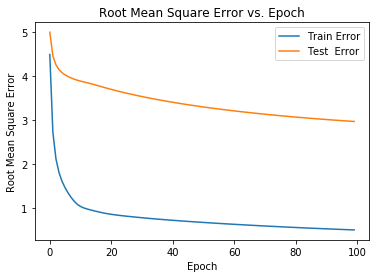

In [72]:
plt.plot(train_errors_RMSE_SGD, label='Train Error')
plt.plot(test_errors_RMSE_SGD, label='Test  Error')
plt.title("Root Mean Square Error vs. Epoch")
plt.xlabel('Epoch')
plt.ylabel('Root Mean Square Error')
plt.legend(loc='best')
plt.show()

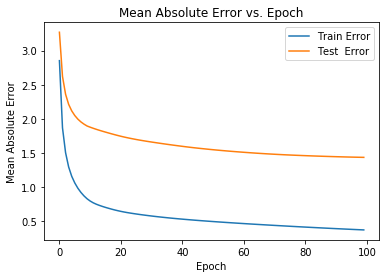

In [73]:
plt.plot(train_errors_MAE_SGD, label='Train Error')
plt.plot(test_errors_MAE_SGD, label='Test  Error')
plt.title("Mean Absolute Error vs. Epoch")
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.show()

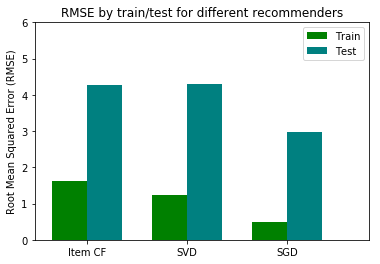

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)
 
# the data
N = 3

# necessary variables
index = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars
opacity = 0.8

## the bars
rects1 = ax.bar(index, trainRMSE[0:3], width, color='green')
rects2 = ax.bar(index+width, testRMSE[0:3], width, color='teal')
 
# axes and labels
ax.set_xlim(-width,len(index))
ax.set_ylim(0,6)
ax.set_ylabel('Root Mean Squared Error (RMSE)')
ax.set_title('RMSE by train/test for different recommenders')
xTickMarks = ['Item CF', 'SVD','SGD']
ax.set_xticks(index+width/2)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, fontsize=10)

## add a legend
ax.legend((rects1[0], rects2[0]), ('Train', 'Test'))

plt.show()
fig.savefig("rmse_train_test.png")

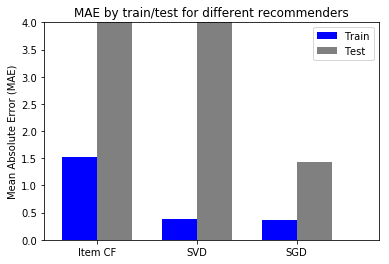

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111)
 
# the data
N = 3

# necessary variables
index = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars
opacity = 0.8

## the bars
rects1 = ax.bar(index, trainMAE[0:3], width, color='blue')
rects2 = ax.bar(index+width, testMAE[0:3], width, color='grey')
 
# axes and labels
ax.set_xlim(-width,len(index))
ax.set_ylim(0,4)
ax.set_ylabel('Mean Absolute Error (MAE)')
ax.set_title('MAE by train/test for different recommenders')
xTickMarks = ['Item CF','SVD','SGD']
ax.set_xticks(index+width/2)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, fontsize=10)

## add a legend
ax.legend((rects1[0], rects2[0]), ('Train', 'Test'))

plt.show()
fig.savefig("mae_train_test.png")

In [76]:
# Note: Put category instead of all restaurant

def get_similar_restaurants_based_on_category(user_reviews_df, businessId, target_df):
    new_reviews = user_reviews_df.loc[user_reviews_df['business_id'] == businessId, 'text']
    new_categories = user_reviews_df.loc[user_reviews_df['business_id'] == businessId, 'categories']

    df_yelp_business = target_df[['business_id', 'categories', 'city', 'name']]
    df_yelp_business.drop_duplicates(inplace=True)
    df_yelp_business

    
    businessxreview = sparse.csr_matrix(pd.get_dummies(target_df['business_id']).values)

    vectorizer_reviews = CountVectorizer(min_df=.01, max_df=.99, tokenizer=WordPunctTokenizer().tokenize)
    vectorized_reviews = vectorizer_reviews.fit_transform(target_df['text'])

    vectorizer_categories = CountVectorizer(min_df=1, max_df=1., tokenizer=lambda x: x.split(', '))
    vectorized_categories = vectorizer_categories.fit_transform(df_yelp_business['categories'])

    from scipy.spatial.distance import cdist
    dists1 = cdist(vectorizer_reviews.transform(new_reviews).todense().mean(axis=0),
                   vectorized_reviews.T.dot(businessxreview).T.todense(),
                   metric='correlation')
    # find most similar categories
    dists2 = cdist(vectorizer_categories.transform(new_categories).todense().mean(axis=0),
                   vectorized_categories.todense(),
                   metric='correlation')


    dists_together = np.vstack([dists1.ravel(), dists2.ravel()]).T

    dists = dists_together.mean(axis=1)
    closest = dists.argsort().ravel()[:10]

    return df_yelp_business.loc[
        df_yelp_business['business_id'].isin(df_yelp_business['business_id'].iloc[closest]),
        ['business_id','categories', 'city','name']
    ]

